# 1 Introduction

## Commentaires

### V2: Adaptation de la V1 sur train_V2 (meilleur modèle =best_LGBM)

- impact sur shap_values (LinearExplainer remplacé par Explainer (pb format array des shapvalues avec TreeExplainer))
- en // modification de la fonction def shap_value(cid:int): du repo P7_API_V2

### V1: Sur base train_V1

Cette version semble fonctionner: je réussis à appeler un SK_ID dans l'API qui me renvoie les shap.values

=> modèle splitté en 3: 

    - la partie sampler (qui elle ne sembe pas s'appliquer => j'ai toujours 61498 lignes dans mon df shap values)
    - la partie transformer (transfromer2) = imputer + standard scaler
    - la partie estimateur (LogReg2)

=> A inclure dans P7_2_1 pour vérifier quele shap.base est identique dans l'onglet 'Shap_test' et dans l'onglet 'shap_val

### Remarque: différence entre .loc et .iloc dans le résultat affiché dans l'API

Ave iloc pas d'index affiché / Avec .loc index affiché suivi de : puis donnée souhaitée (impact ajout d'une couche de dictionnaire)

=> Tester le passage du SK_ID dans l'index...

In [7]:
pwd

'c:\\Users\\xavie\\P7\\P7_ML_model'

## 1.1 Imports

In [89]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
#from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as Pipeline_imb
import lightgbm as lgb
from lightgbm import LGBMClassifier
import pickle
import shap
shap.initjs()

## 1.2 Fonctions utiles

In [9]:
from src.fonctions import result, print_score, decomposition_modele

In [10]:
pd.set_option('display.max_columns', None)

In [11]:
DISPLAY=True

"""If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.
Else they will

This short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"""

"If Dispaly == False then all cell starting starting with 'If Display=True' won't be ran.\nElse they will\n\nThis short function allows to by-pass instructions which are long to run (ex MSNO on huge dataset or sns.pairplot)"

# 2 Data

## 2.1 Import and display

In [39]:
train_V2=pd.read_csv('../train_V2.csv')

In [40]:
train_V2.shape

(307455, 31)

In [41]:
train_V2=train_V2.sample(frac=0.2)
train_V2.shape

(61491, 31)

# 3 Best model: best_lgbm

In [42]:
best_LGBM=Pipeline_imb([
    ('sampler',RandomUnderSampler()),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler()),
    ('estimator',LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))
])
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [43]:
X=train_V2.drop(['SK_ID_CURR','TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X.shape

(61491, 23)

In [44]:
y=train_V2['TARGET']
y.shape

(61491,)

# 4 Adaptation modèle pour appel SHAP dans l'API

Rappel: Shap ne prend que l'estimateur (et pas le pipeline entier) pour calculer explaienr/shap_values

Or en récupérant le best_lgbm, et en le décomposant, dans l'API je dois faire appel à l'Id des crédits/clients. Cet Id n'est pas utilisé dans le best_lgbml.

2 solutions:

- 1/ j'ajoute l'id dans le bet_model, au risque d'avoir des résultats un peu moins bons => partie 4.1
- 2/ Comme pour l'AMNT_GOOD_PRICE (cf notebook ML), je reconstitue le df après l'entrainement => partie 4.2


## 4.1 Ajout de SK_ID_CURR après entrainement de best_model

- X: df sans SK_ID
- X2: df avec SK_ID

Etapes:

=> RandomUnderSampler sur X2
=> imputer sur X2
=> Suppression de SK_ID_CURR
=> transformer
=>fit LGBM

### New dataframe X2 avec SK_ID_CURR

In [45]:
X2=train_V2.drop(['TARGET','OWN_CAR_AGE','NAME_HOUSING_TYPE','AMT_GOODS_PRICE','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_EDUCATION_TYPE'],axis=1)
X2.shape


(61491, 24)

In [46]:
y2=y
y2.shape

(61491,)

### Train test split sur base X2

In [47]:
X2

,SK_ID_CURR,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
183296,312492,0,0,135000.0,407965.5,27261.0,1.0,0.240236,0.179534,NaN,0.0,0.000,0.000000,0.0,0.330910,0.201933,0.066822,25,2.0,135000.0,1,0,1,0
209135,342441,0,1,90000.0,382500.0,19660.5,2.0,NaN,0.337417,0.612704,8.0,3092062.500,0.333333,0.0,0.235294,0.218450,0.051400,64,-0.0,45000.0,1,0,0,1
254165,394167,0,1,252000.0,405000.0,20250.0,3.0,NaN,0.197473,0.644679,0.0,0.000,0.333333,0.0,0.622222,0.080357,0.050000,41,9.0,84000.0,0,1,1,0
168294,295113,0,1,247500.0,417024.0,20191.5,2.0,NaN,0.755947,0.128504,0.0,0.000,0.000000,0.0,0.593491,0.081582,0.048418,53,6.0,123750.0,1,1,1,1
123522,243273,0,0,153000.0,334152.0,17059.5,2.0,0.743332,0.303299,NaN,0.0,0.000,0.500000,0.0,0.457875,0.111500,0.051053,36,0.0,76500.0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262907,404498,0,1,112500.0,314100.0,16573.5,4.0,0.498774,0.718717,0.392774,19.0,7226719.245,0.333333,1.0,0.358166,0.147320,0.052765,30,1.0,28125.0,1,1,1,1
164033,290187,1,1,135000.0,427450.5,20691.0,2.0,NaN,0.399361,0.789880,0.0,0.000,0.750000,0.0,0.315826,0.153267,0.048406,63,-0.0,67500.0,1,1,0,1
6378,107441,0,1,101250.0,549882.0,17869.5,2.0,NaN,0.701521,0.605836,0.0,0.000,0.000000,0.0,0.184130,0.176489,0.032497,58,5.0,50625.0,1,1,1,1
227136,363140,1,0,157500.0,241618.5,26149.5,1.0,NaN,0.453905,0.621226,0.0,0.000,0.000000,0.0,0.651854,0.166029,0.108226,26,1.0,157500.0,1,0,1,0


In [48]:
X_train,X_test,y_train,y_test=train_test_split(X2,y2,test_size=0.2)

In [49]:
print('Train set:',X_train.shape)
print('Test set:',X_test.shape)
print('Train target:',y_train.shape)
print('Test target:',y_test.shape)

Train set: (49192, 24)
Test set: (12299, 24)
Train target: (49192,)
Test target: (12299,)


### Decomposition du best_lgm

In [54]:
best_LGBM

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('estimator',
                 LGBMClassifier(max_depth=3, min_data_in_leaf=500,
                                num_leaves=20))])

In [56]:
 #Sampling 
X_train_rus, y_train_rus=best_LGBM[0].fit_resample(X_train,y_train)
X_train_rus.shape

In [58]:
# Fill Nan with simple imputer(median)
X_tr=pd.DataFrame(best_LGBM[1].fit_transform(X_train_rus),columns=X_train_rus.columns)
X_tr.shape

(7776, 24)

In [59]:
# Suppression du SK_ID_CURR
X_tmp=X_tr.drop(['SK_ID_CURR'],axis=1)
X_tmp.shape

(7776, 23)

In [61]:
best_LGBM[2]

StandardScaler()

In [62]:
# Scaling
X_tr_transf=pd.DataFrame(best_LGBM[2].fit_transform(X_tmp), columns=X_tmp.columns)
X_tr_transf.shape

(7776, 23)

In [63]:
X_tr_transf.isna().sum()

FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
AMT_INCOME_TOTAL       0
AMT_CREDIT             0
AMT_ANNUITY            0
CNT_FAM_MEMBERS        0
EXT_SOURCE_1           0
EXT_SOURCE_2           0
EXT_SOURCE_3           0
Prev_contract_nb       0
Prev_AMT_CREDIT        0
Refused_rate           0
default_payment        0
INCOME_CREDIT_PERC     0
ANNUITY_INCOME_PERC    0
PAYMENT_RATE           0
client_age             0
client_prof_exp        0
INCOME_PER_PERSON      0
Cash_loans             0
GENDER_FEMALE          0
active_client          0
relationship           0
dtype: int64

In [64]:
# Entrainement
best_LGBM[-1].fit(X_tr_transf,y_train_rus)

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Info] Number of positive: 3888, number of negative: 3888
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2855
[LightGBM] [Info] Number of data points in the train set: 7776, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warn

LGBMClassifier(max_depth=3, min_data_in_leaf=500, num_leaves=20)

Conclusion => décompostion du modèle en 3 étape:

-> Random Under Sampling + Imputer

-> Scaler

-> LGBM())

### Enregistrement pkl

In [81]:
best_LGBM[:-2]

Pipeline(steps=[('sampler', RandomUnderSampler()),
                ('imputer', SimpleImputer(strategy='median'))])

In [65]:
best_LGBM[-2]

StandardScaler()

In [82]:
pickle_out = open("samplerV2.pkl","wb")
pickle.dump(best_LGBM[:-2], pickle_out)
pickle_out.close()

In [83]:
pickle_out = open("transformer2_V2.pkl","wb")
pickle.dump(best_LGBM[-2], pickle_out)
pickle_out.close()

In [66]:
pickle_out = open("est_LGBM.pkl","wb")
pickle.dump(best_LGBM[-1], pickle_out)
pickle_out.close()

# 5 Tests pour l'API:

Ci dessous: pas à pas de la fonction shap_value(cid:int) du repo P7_API_V2

In [68]:
X2.shape

(61491, 24)

In [70]:
transf_data = pd.DataFrame(best_LGBM[:-2].transform(X2),columns = X2.columns) # fit_resample necessite (X,y)
transf_data.shape

(61491, 24)

In [71]:
data_for_shap=transf_data.drop(['SK_ID_CURR'],axis=1)

In [72]:
data_for_shap_tr=pd.DataFrame(best_LGBM[-2].transform(data_for_shap),columns=data_for_shap.columns)

In [73]:
best_LGBM[-1]

LGBMClassifier(max_depth=3, min_data_in_leaf=500, num_leaves=20)

## Création de l'explaner Shap et des Shap_values

In [115]:
explainer=shap.Explainer(best_LGBM[-1],data_for_shap_tr)

In [117]:
shap_values = explainer(data_for_shap_tr,check_additivity=False)

 99%|===================| 60715/61491 [00:53<00:00]        

## Importance globale

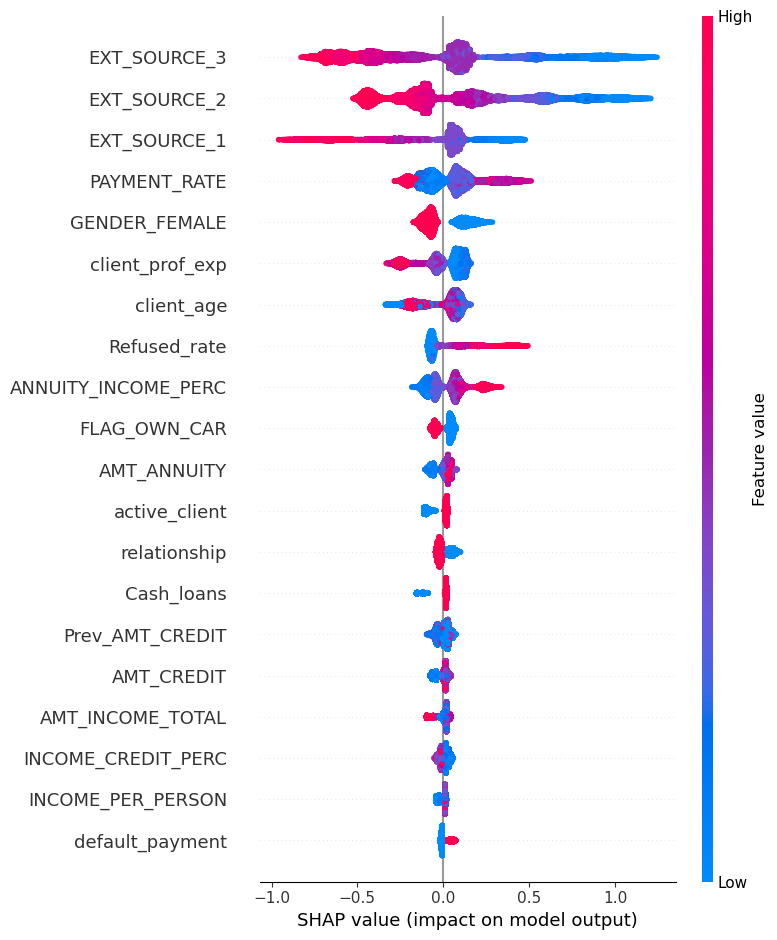

In [121]:
shap.summary_plot(shap_values,data_for_shap)

## Importance locale

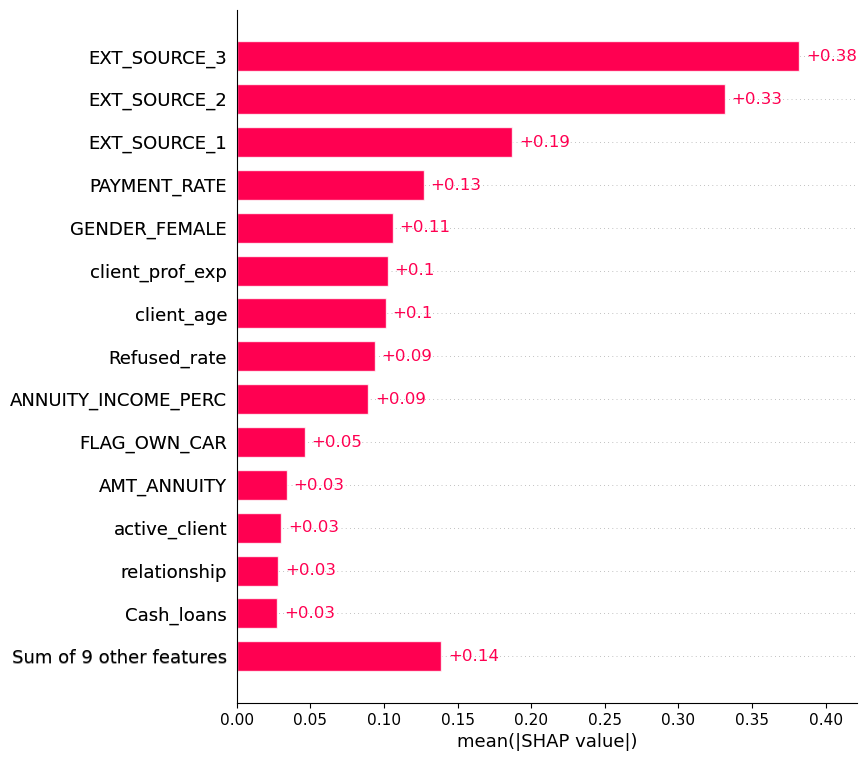

In [127]:
shap.plots.bar(shap_values,max_display=15)

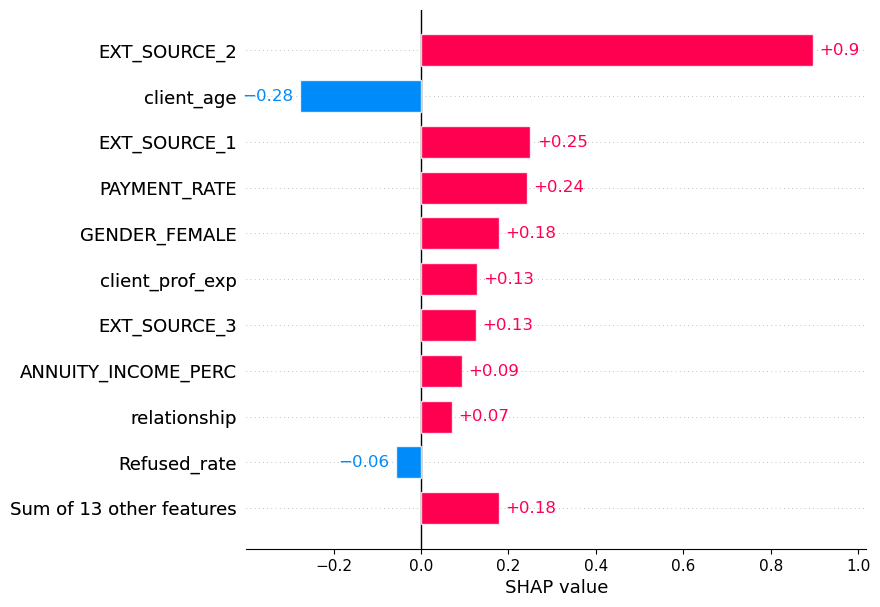

In [128]:
shap.plots.bar(shap_values[0],max_display=11)

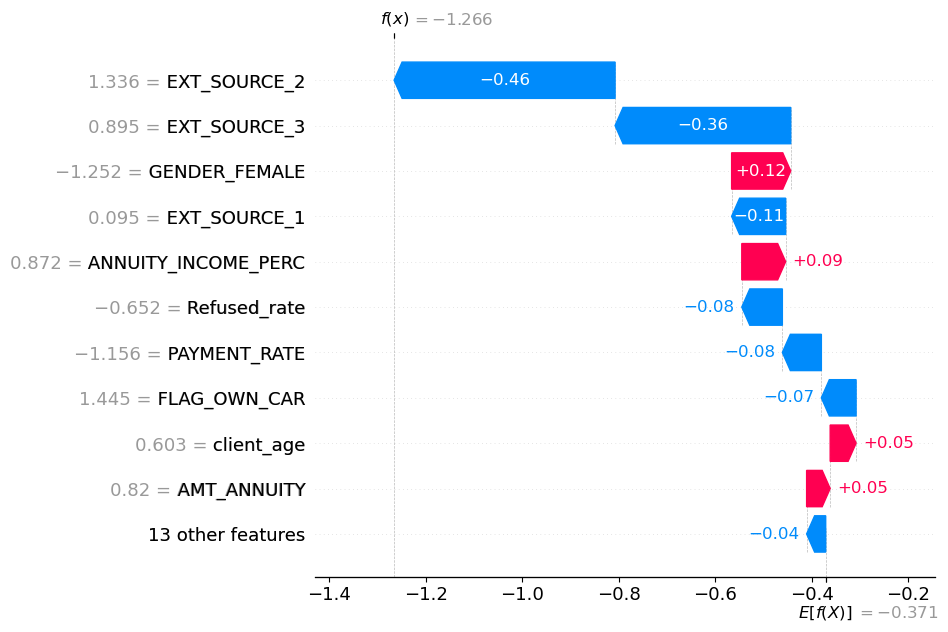

In [144]:
shap.waterfall_plot(shap_values[5], max_display=11)

In [167]:

shap.force_plot(explainer.expected_value,
                explainer.shap_values(data_for_shap.iloc[0]),
                feature_names=data_for_shap.columns)
                #out_names="Conso")

In [168]:
svv=pd.DataFrame(shap_values.values, columns = data_for_shap.columns).round(2)
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship
0,0.03,0.0,0.02,0.02,0.03,0.0,0.25,0.90,0.13,0.01,0.05,-0.06,-0.01,-0.01,0.09,0.24,-0.28,0.13,-0.00,0.02,0.18,0.02,0.07
1,0.05,0.0,0.00,0.01,0.02,0.0,0.03,0.56,-0.39,-0.00,-0.02,0.07,-0.01,0.01,0.08,0.09,-0.19,0.08,-0.02,0.02,0.19,-0.10,-0.03
2,0.03,0.0,0.04,0.00,0.00,0.0,0.06,0.77,-0.46,0.03,0.03,0.09,-0.01,-0.02,-0.10,0.07,0.04,-0.06,0.01,-0.15,-0.13,0.02,0.03
3,0.04,0.0,0.02,0.02,-0.01,0.0,0.09,-0.51,1.02,0.01,0.01,-0.08,-0.01,-0.02,-0.09,0.13,0.07,-0.03,0.01,0.02,-0.05,0.01,-0.02
4,0.05,0.0,0.02,0.01,0.01,0.0,-0.80,0.58,0.05,0.01,0.02,0.19,-0.01,-0.03,-0.08,0.13,0.09,0.10,0.01,0.02,0.16,0.02,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,0.04,0.0,0.01,0.01,-0.00,0.0,-0.26,-0.38,0.06,-0.02,0.00,0.16,0.04,-0.03,-0.05,0.08,0.08,0.11,-0.04,0.02,-0.07,0.01,-0.01
61487,-0.04,0.0,0.01,0.01,0.02,0.0,0.04,0.19,-0.81,0.01,0.01,0.35,-0.01,-0.03,-0.05,0.14,-0.19,0.07,0.01,0.02,-0.12,-0.11,-0.02
61488,0.05,0.0,-0.00,0.01,-0.02,0.0,0.03,-0.46,-0.43,0.01,0.01,-0.08,-0.01,0.03,0.06,-0.05,-0.15,-0.00,-0.02,0.01,-0.08,0.02,-0.03
61489,-0.04,0.0,0.01,-0.04,0.04,0.0,0.06,0.15,-0.43,0.01,0.03,-0.06,-0.01,-0.01,-0.02,-0.18,-0.10,0.09,0.00,0.02,0.18,0.02,0.08


In [169]:
svv['SK_ID_CURR']=transf_data['SK_ID_CURR']
svv

,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,Prev_contract_nb,Prev_AMT_CREDIT,Refused_rate,default_payment,INCOME_CREDIT_PERC,ANNUITY_INCOME_PERC,PAYMENT_RATE,client_age,client_prof_exp,INCOME_PER_PERSON,Cash_loans,GENDER_FEMALE,active_client,relationship,SK_ID_CURR
0,0.03,0.0,0.02,0.02,0.03,0.0,0.25,0.90,0.13,0.01,0.05,-0.06,-0.01,-0.01,0.09,0.24,-0.28,0.13,-0.00,0.02,0.18,0.02,0.07,312492.0
1,0.05,0.0,0.00,0.01,0.02,0.0,0.03,0.56,-0.39,-0.00,-0.02,0.07,-0.01,0.01,0.08,0.09,-0.19,0.08,-0.02,0.02,0.19,-0.10,-0.03,342441.0
2,0.03,0.0,0.04,0.00,0.00,0.0,0.06,0.77,-0.46,0.03,0.03,0.09,-0.01,-0.02,-0.10,0.07,0.04,-0.06,0.01,-0.15,-0.13,0.02,0.03,394167.0
3,0.04,0.0,0.02,0.02,-0.01,0.0,0.09,-0.51,1.02,0.01,0.01,-0.08,-0.01,-0.02,-0.09,0.13,0.07,-0.03,0.01,0.02,-0.05,0.01,-0.02,295113.0
4,0.05,0.0,0.02,0.01,0.01,0.0,-0.80,0.58,0.05,0.01,0.02,0.19,-0.01,-0.03,-0.08,0.13,0.09,0.10,0.01,0.02,0.16,0.02,-0.03,243273.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61486,0.04,0.0,0.01,0.01,-0.00,0.0,-0.26,-0.38,0.06,-0.02,0.00,0.16,0.04,-0.03,-0.05,0.08,0.08,0.11,-0.04,0.02,-0.07,0.01,-0.01,404498.0
61487,-0.04,0.0,0.01,0.01,0.02,0.0,0.04,0.19,-0.81,0.01,0.01,0.35,-0.01,-0.03,-0.05,0.14,-0.19,0.07,0.01,0.02,-0.12,-0.11,-0.02,290187.0
61488,0.05,0.0,-0.00,0.01,-0.02,0.0,0.03,-0.46,-0.43,0.01,0.01,-0.08,-0.01,0.03,0.06,-0.05,-0.15,-0.00,-0.02,0.01,-0.08,0.02,-0.03,107441.0
61489,-0.04,0.0,0.01,-0.04,0.04,0.0,0.06,0.15,-0.43,0.01,0.03,-0.06,-0.01,-0.01,-0.02,-0.18,-0.10,0.09,0.00,0.02,0.18,0.02,0.08,363140.0
